# Introduction - Scoring CDS multivalency across the transcriptome
This notebook produces several types of transcript-level multivalency scores, based on most multivalent GeRM peaks (top 2%) found in an ensembl of human coding sequences.

Multivalency was scored across entire spliced transcript CDSs for 5mers. The number of scored positions in the multivalency table thus equals: tx_lengh - 4

To calculate multivalency transcriptome wide, we used a k-mer length (𝑘) of 5, a window size (𝑛) of 123, and a scaling factor (λ) of 1. We normalised the GeRM scores such that the minimum value in the transcriptome was 0 and the median was 1. Smoothing of GeRM scores was performed by taking the mean of values in a sliding window of size 123.

To score transcript MV:
1. K-mers defined based on top 2% GeRM regions, where the top 2% of k-mer multivalent peaks were clustered into 8 clusters based on k-mers that contributed to multivalency. For each of the clusters representative k-mers were selected, as those that accounted for top 50% oc multivalency in that particular cluster. K-mers that contributed to multiple clusters were only kept in the cluster where they contributed most.

# Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# Set output path
out_path = '../results/ModelDatasets/'
out_general = '../results/general/'
os.makedirs(out_path, exist_ok=True)
os.makedirs(out_general, exist_ok=True)

In [3]:
# Load data
# GeRM output
rawkmermv = '../data/2023_Faraway/all_kmer_multivalencies.tsv.gz'
# Transcript info
dfTxInfo = pd.read_csv('../data/2023_Faraway/longest_proteincoding_transcript_hs_details_exons.txt', sep='\t')

# Tables for k-mer cluster definition
# Proportion of k-mers in CDS multivalent peaks - this is used to define representative k-mers analogous to the 2023 Faraway paper
dfPeakProp = pd.read_csv('../data/2023_Faraway/prop_mv_per_kmer_cds.tsv', sep='\t')

# Get CDS multivalency and standard-scale values for each k-mer
I checked that obtained CDS size corresponded to size recorded in transcript info dataframe.

In [4]:
mvFile = f'{out_path}RawMv_TranscriptSumPerKmer.tsv'

if os.path.exists(mvFile):
    dfMvSum = pd.read_csv(mvFile, sep='\t', low_memory=False)
else:
    # Load only necessary columns
    usecols = ['sequence_name', 'kmer', 'kmer_multivalency']
    dfRawMV = pd.read_csv(rawkmermv, sep='\t', usecols=usecols, compression='gzip', low_memory=False)

    # Preprocess dfTxInfo
    dfTxInfo = dfTxInfo[['transcript_id', 'gene_id', 'cds_start', 'cds_end', 'cds_length']].copy()
    dfTxInfo['gene_id'] = dfTxInfo['gene_id'].str.split('.').str[0]

    # Merge transcript information
    dfRawMV = dfRawMV.merge(dfTxInfo, left_on='sequence_name', right_on='transcript_id', how='left')
    dfRawMV.drop(columns=['sequence_name', 'transcript_id'], inplace=True)

    # Add position
    dfRawMV['position'] = dfRawMV.groupby('gene_id').cumcount() + 1 # We use a 1 based indexing system

    # Assign region using vectorized logic
    # If position is less than CDS start, annotate as 5' UTR, if greater than CDS end, annotate as 3' UTR, else annotate as CDS
    dfRawMV['region'] = np.where(dfRawMV['position'] < dfRawMV['cds_start'], '5UTR',
                         np.where(dfRawMV['position'] > dfRawMV['cds_end'], '3UTR', 'CDS'))

    # Keep only CDS entries
    dfRawMV = dfRawMV[dfRawMV['region'] == 'CDS']

    # Downcast types for memory efficiency
    dfRawMV['kmer_multivalency'] = dfRawMV['kmer_multivalency'].astype('float32')
    dfRawMV['position'] = dfRawMV['position'].astype('int32')
    dfRawMV['cds_start'] = dfRawMV['cds_start'].astype('int32')
    dfRawMV['cds_end'] = dfRawMV['cds_end'].astype('int32')
    dfRawMV['gene_id'] = dfRawMV['gene_id'].astype('category')
    dfRawMV['kmer'] = dfRawMV['kmer'].astype('category')

    # Save full processed data (optional)
    dfRawMV.to_csv(mvFile, sep='\t', index=False)

    # Compute kmer multivalency sum per gene
    dfMvSum = dfRawMV.groupby(['gene_id', 'kmer'])['kmer_multivalency'].sum().reset_index()

    # Save summary
    dfMvSum.to_csv(f'{out_path}RawMv_TranscriptSumPerKmer.tsv', sep='\t', index=False)

In [5]:
dfMvSum.head()

,gene_id,kmer,kmer_multivalency
0,ENSG00000000003,AAAAA,2.199869
1,ENSG00000000003,AAAAC,0.680860
2,ENSG00000000003,AAAAG,2.062640
3,ENSG00000000003,AAAAT,2.147305
4,ENSG00000000003,AAACA,2.357274


## Get representative k-mers for each cluster

A-rich Pur. has 29
['AAAAA', 'AAGAA', 'AGAAA', 'AAAGA', 'GAAAA', 'AAAAG', 'GAAGA', 'AGAAG', 'GAGAA', 'AGAGA', 'AAGAG', 'GAAAG', 'AAGGA', 'AGGAA', 'AAAAT', 'CAAAA', 'AAACA', 'AAAGG', 'GGAAA', 'AAAAC', 'TAAAA', 'ACAAA', 'AACAA', 'ATAAA', 'TGAAA', 'AAGAT', 'CAGAA', 'AAATA', 'CAAGA']
C-rich has 42
['CCCCC', 'CCACC', 'CCCCA', 'GCCCC', 'CCTCC', 'CACCA', 'CCCAC', 'CACCC', 'ACCAC', 'ACCCC', 'CCCCT', 'CAGCC', 'CCAGC', 'CCCAG', 'CCCTC', 'CTCCC', 'CCGCC', 'TCCCC', 'AGCCC', 'GGCCC', 'CCCCG', 'CTGCC', 'CCCTG', 'CCTGC', 'CCCGC', 'GCCAC', 'CTCCA', 'CGCCC', 'CTCCT', 'GCCCA', 'TGCCC', 'CACCT', 'GCAGC', 'CAGCA', 'TCCTC', 'CCACA', 'GCCTC', 'TCCAC', 'ACCTC', 'GCACC', 'CCAGG', 'ACCCA']
CAG-rep has 24
['CAGCA', 'GCAGC', 'AGCAG', 'ACAGC', 'CAACA', 'CAGCC', 'AGCAA', 'AACAG', 'GCAAC', 'CCAGC', 'GCCGC', 'GCAGT', 'CCGCC', 'GCGGC', 'AGTGA', 'CAGCT', 'CCACC', 'CAGTG', 'GGCAG', 'GACAG', 'CACCA', 'CAGCG', 'GGAGC', 'CCCAG']
CU-rich has 42
['CCTCC', 'TCCTC', 'CTCCT', 'TCTTC', 'CCTCT', 'CCCCC', 'CCACC', 'CTTCC', 'CCCTC

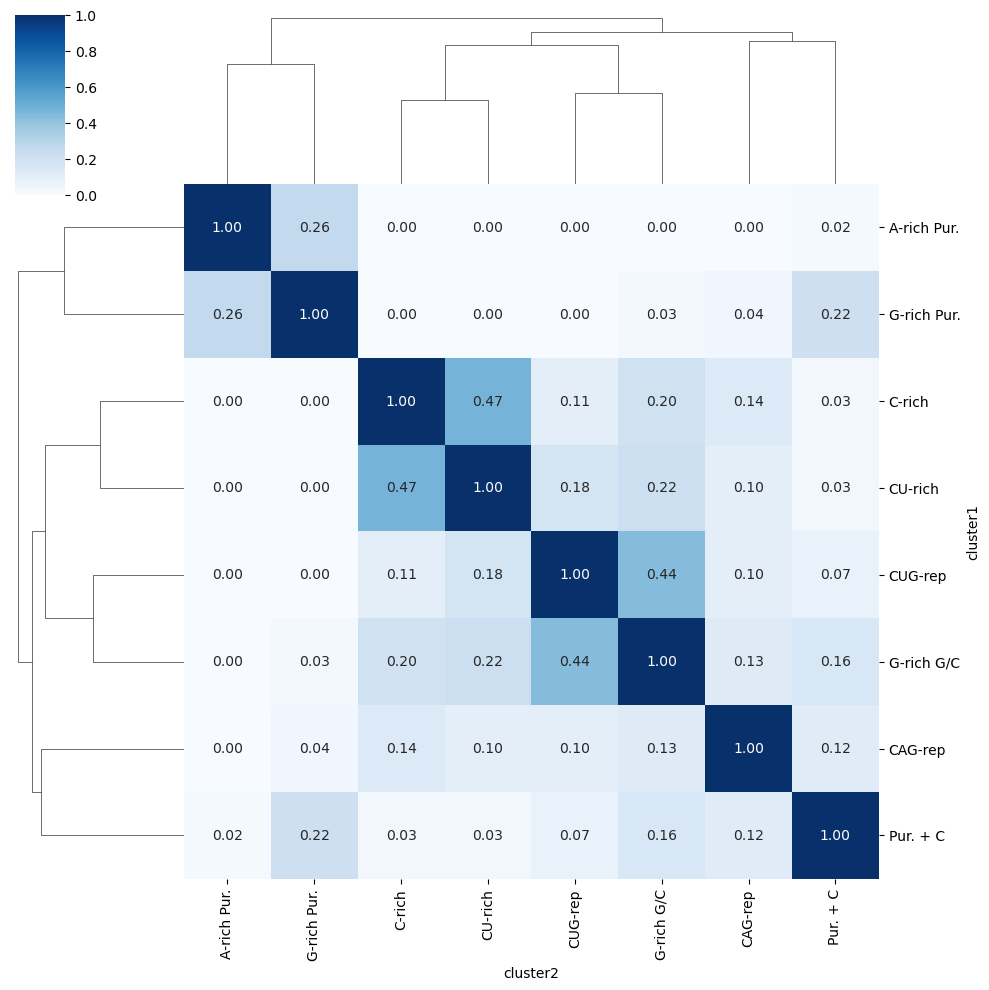

In [6]:
# For each cluster compute the cumulative sum
# Take all 5-mers that account for the first 50% of the multivalency in each GeRM region were taken forward as representative 5-mers for those regions.
GermBasedClusters = {}
for cl, df in dfPeakProp.groupby('cluster_name_short'):
    # Sort from highest to lowest multivalency
    df = df.sort_values('mean_prop_mv', ascending=False)
    df['cumsum'] = df['mean_prop_mv'].cumsum()
    kmers = df.loc[df['cumsum'] <= 0.5, 'kmer'].values.tolist()
    print(f'{cl} has {len(kmers)}')
    print(kmers)
    GermBasedClusters[cl] = kmers

# filter dfPeakProp to k-mers in GermBasedClusters
allKmers = set([k for kmers in GermBasedClusters.values() for k in kmers])
dfPeakProp = dfPeakProp[dfPeakProp['kmer'].isin(allKmers)]

# Investigate the the overlap betwer Rupert's k-mer clusters (compute Jaccard index)
# Compute Jaccard index between all pairs of clusters
rows = []
for cl1 in GermBasedClusters.keys():
    for cl2 in GermBasedClusters.keys():
        jaccard = len(set(GermBasedClusters[cl1]).intersection(GermBasedClusters[cl2])) / len(set(GermBasedClusters[cl1]).union(GermBasedClusters[cl2]))
        rows.append({'cluster1': cl1, 'cluster2': cl2, 'jaccard': jaccard})
dfJaccard = pd.DataFrame(rows)
# Pivot table
dfJaccard = dfJaccard.pivot(index='cluster1', columns='cluster2', values='jaccard')
# Plot
g = sns.clustermap(dfJaccard, cmap='Blues', annot=True, fmt=".2f")
plt.savefig(f'{out_path}GermBasedClustersJaccard.pdf')
plt.show()

In [7]:
# Handle overlapping k-mers - only retain a k-mer in the cluster where it had the biggest contribution to MV
dfPeakProp = dfPeakProp.sort_values('mean_prop_mv', ascending=False).drop_duplicates('kmer', keep='first')
# print the number of k-mers per cluster
print(dfPeakProp.groupby('cluster_name_short').size())
# Print k-mers in each cluster
for cl, df in dfPeakProp.groupby('cluster_name_short'):
    print(f'{cl} has {df.shape[0]} k-mers')
    print(df['kmer'].values)

cluster_name_short
A-rich Pur.    25
C-rich         28
CAG-rep        12
CU-rich        16
CUG-rep        18
G-rich G/C     28
G-rich Pur.    19
Pur. + C       21
dtype: int64
A-rich Pur. has 25 k-mers
['AAAAA' 'AAGAA' 'AGAAA' 'AAAGA' 'GAAAA' 'AAAAG' 'GAGAA' 'AGAGA' 'GAAAG'
 'AAGGA' 'AAAAT' 'CAAAA' 'AAACA' 'AAAGG' 'GGAAA' 'AAAAC' 'TAAAA' 'ACAAA'
 'AACAA' 'ATAAA' 'TGAAA' 'AAGAT' 'CAGAA' 'AAATA' 'CAAGA']
C-rich has 28 k-mers
['CCCCC' 'CCACC' 'CCCCA' 'GCCCC' 'CACCA' 'CCCAC' 'CACCC' 'ACCAC' 'ACCCC'
 'CCCCT' 'CAGCC' 'CCAGC' 'CCCAG' 'CCCTC' 'CTCCC' 'TCCCC' 'AGCCC' 'CCCTG'
 'GCCAC' 'CTCCA' 'GCCCA' 'TGCCC' 'CACCT' 'CCACA' 'ACCTC' 'GCACC' 'CCAGG'
 'ACCCA']
CAG-rep has 12 k-mers
['CAGCA' 'GCAGC' 'AGCAG' 'ACAGC' 'CAACA' 'AGCAA' 'AACAG' 'GCAAC' 'GCAGT'
 'AGTGA' 'CAGTG' 'GACAG']
CU-rich has 16 k-mers
['CCTCC' 'TCCTC' 'CTCCT' 'TCTTC' 'CCTCT' 'CTTCC' 'TTCCT' 'CTCTT' 'CTTCT'
 'TTCTT' 'GCCTC' 'TCTCC' 'TCCAC' 'TCCTG' 'TCATC' 'CCTTC']
CUG-rep has 18 k-mers
['GCTGC' 'CTGCT' 'TGCTG' 'CTGCC' 'CCTGC' 'GGCTG'

In [8]:
dfPeakProp.head()

,cluster_name,kmer,mean_prop_mv,cluster,cluster_colour,cluster_name_short,new_order
1314,CAGCA/GCAGC/AGCAG,CAGCA,0.122309,8,#0F8554,CAG-rep,8
1606,CAGCA/GCAGC/AGCAG,GCAGC,0.108947,8,#0F8554,CAG-rep,8
1170,CAGCA/GCAGC/AGCAG,AGCAG,0.104846,8,#0F8554,CAG-rep,8
6667,GCTGC/CTGCT/TGCTG,GCTGC,0.088622,5,#5F4690,CUG-rep,5
3428,CCTCC/TCCTC/CTCCT,CCTCC,0.074331,6,#666666,CU-rich,7


In [9]:
# Make a dataframe of the clusters
dfGermBasedClusters = dfPeakProp[['kmer', 'cluster_name_short']].copy().rename(columns={'cluster_name_short': 'GermBasedCluster'}).reset_index(drop=True)
# Save Rupert's clusters to general results
dfGermBasedClusters.to_csv(f'{out_general}release_GermRegionBasedKmerClusters.tsv', sep='\t', index=False)

In [10]:
dfGermBasedClusters.head()

,kmer,GermBasedCluster
0,CAGCA,CAG-rep
1,GCAGC,CAG-rep
2,AGCAG,CAG-rep
3,GCTGC,CUG-rep
4,CCTCC,CU-rich


In [11]:
nRupKmers = dfGermBasedClusters['GermBasedCluster'].value_counts()
print(nRupKmers)

GermBasedCluster
G-rich G/C     28
C-rich         28
A-rich Pur.    25
Pur. + C       21
G-rich Pur.    19
CUG-rep        18
CU-rich        16
CAG-rep        12
Name: count, dtype: int64


## Score transcripts in terms of k-mer cluster multivalency

In [12]:
# Add cluster columns to the multivalency sum table
dfMvSum = dfMvSum.merge(dfGermBasedClusters, on='kmer', how='left')

In [13]:
# Score transcripts based on the sum of multivalency scores for each k-mer cluster
dfTotalMV = dfMvSum.groupby(['gene_id', 'GermBasedCluster'])[['kmer_multivalency']].sum().reset_index()

In [14]:
# Convert gene_id to stable gene_id
dfTxInfo['gene_id'] = dfTxInfo['gene_id'].str.split('.').str[0]
# Add group info and filter for genes that were classified into response groups
dfTotalMV = dfTotalMV.merge(dfTxInfo[['gene_id', 'cds_length']], on='gene_id', how='inner')

# Add number of cluster k-mers to table
dfTotalMV = dfTotalMV.merge(nRupKmers, on='GermBasedCluster', how='left')

# Compute a length-normalised kmer_multivalency
dfTotalMV['lenNorm_kmer_multivalency (per kb)'] = dfTotalMV['kmer_multivalency'] * 1000 / dfTotalMV['cds_length']

# Standardise lenNorm_kmer_multivalency (per kb) for each cluster
scaler = StandardScaler()
dfTotalMV['scaled_lenNorm_kmer_multivalency (per kb)'] = dfTotalMV.groupby('GermBasedCluster')['lenNorm_kmer_multivalency (per kb)'].transform(lambda x: scaler.fit_transform(x.values[:,np.newaxis]).ravel())

# Reorder columns
dfTotalMV = dfTotalMV[[c for c in dfTotalMV.columns if 'multiv' not in c] + [c for c in dfTotalMV.columns if 'multiv' in c]]

# Rename columns
renaming = {
    'GermBasedCluster': 'Cluster',
    'count': 'N_KmersPerCluster',
    'kmer_multivalency': 'RawMVScoreSum', 
    'lenNorm_kmer_multivalency (per kb)': 'LengthNorm_MVScoreSum (per kb)',
    'scaled_lenNorm_kmer_multivalency (per kb)': 'StandardScaled_LengthNorm_MVScoreSum (per kb)', 
}
dfTotalMV.columns = [renaming.get(c, c) for c in dfTotalMV.columns]

In [15]:
dfTxInfo

,gene_name,gene_id,transcript_id,cds_start,cds_length,tx_length,cds_end,longest_all_exons,number_all_exons,longest_coding_exon,number_coding_exon
0,TSPAN6,ENSG00000000003,ENST00000373020.8,113,738,2206,850,1317,8,189,7
1,TNMD,ENSG00000000005,ENST00000373031.4,218,954,1339,1171,378,7,210,7
2,DPM1,ENSG00000000419,ENST00000371582.8,33,864,1161,896,370,10,161,10
3,SCYL3,ENSG00000000457,ENST00000367772.8,223,2229,3090,2451,699,14,695,13
4,C1orf112,ENSG00000000460,ENST00000286031.10,701,2562,4355,3262,1291,24,198,22
...,...,...,...,...,...,...,...,...,...,...,...
18881,AC093827.5,ENSG00000285458,ENST00000473559.5,665,354,2306,1018,1422,7,155,3
18882,AC134980.3,ENSG00000285472,ENST00000639059.1,982,951,2317,1932,1345,7,951,1
18883,AC067752.1,ENSG00000285551,ENST00000614806.1,154,651,877,804,265,6,265,6
18884,AC097636.1,ENSG00000285749,ENST00000456080.5,1166,465,1685,1630,474,8,399,3


<Axes: xlabel='StandardScaled_LengthNorm_MVScoreSum (per kb)', ylabel='Density'>

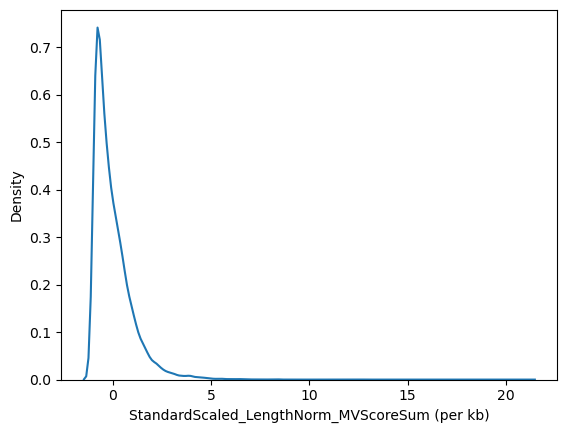

In [16]:
# Check scaling
sns.kdeplot(dfTotalMV.loc[dfTotalMV.Cluster=='A-rich Pur.', 'StandardScaled_LengthNorm_MVScoreSum (per kb)'])

In [17]:
# Save transcript multivalency scores
dfTotalMV.to_csv(f'{out_path}GermBasedKmerClustersMvScores.tsv.gz', sep='\t', index=False, compression='gzip')

In [18]:
dfTotalMV.head()

,gene_id,Cluster,cds_length,N_KmersPerCluster,RawMVScoreSum,LengthNorm_MVScoreSum (per kb),StandardScaled_LengthNorm_MVScoreSum (per kb)
0,ENSG00000000003,A-rich Pur.,738,25,72.665420,98.462628,-0.113790
1,ENSG00000000003,C-rich,738,28,15.712314,21.290399,-1.012727
2,ENSG00000000003,CAG-rep,738,12,13.313329,18.039741,-0.766382
3,ENSG00000000003,CU-rich,738,16,27.475434,37.229586,-0.468040
4,ENSG00000000003,CUG-rep,738,18,20.210764,27.385859,-0.689328
